In [1]:
from google.colab import files
uploaded = files.upload()

Saving drug_embeddings.pt to drug_embeddings.pt
Saving gnn_ddi_model.pt to gnn_ddi_model.pt


In [2]:
!pip install torch-geometric
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE

class GCNEncoder(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super(GCNEncoder,self).__init__()
    self.conv1 = GCNConv(in_channels,128)
    self.conv2 = GCNConv(128,out_channels)

    def forward(self, x, edge_index):
      x = self.conv1(x,edge_index)
      x = F.relu(x)
      x = self.conv2(x,edge_index)
      return x

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.1 MB/s eta 0:00:00


In [3]:
from sklearn.metrics import roc_auc_score, accuracy_score
from torch_geometric.utils import negative_sampling


In [4]:
def predict_interaction(drug1_name, drug2_name, drug_df, model, z):
    d1_row = drug_df[drug_df['name'].str.lower() == drug1_name.lower()]
    d2_row = drug_df[drug_df['name'].str.lower() == drug2_name.lower()]

    if d1_row.empty or d2_row.empty:
        return f"❌ One or both drug names not found in dataset."

    id1 = d1_row['drugbank_id'].values[0]
    id2 = d2_row['drugbank_id'].values[0]

    idx1 = drug_id_to_index.get(id1)
    idx2 = drug_id_to_index.get(id2)

    if idx1 is None or idx2 is None:
        return f"❌ One or both drugs not in trained graph."

    idx1 = int(idx1)
    idx2 = int(idx2)

    score = torch.sigmoid((z[idx1] * z[idx2]).sum()).item()
    return f"✅ Interaction probability between {drug1_name} and {drug2_name}: {score:.4f}"


In [5]:
predict_interaction("Ezetimibe", "Carumonam", drug_df, model, z)


'✅ Interaction probability between Ezetimibe and Carumonam: 0.6227'

In [6]:
from torch_geometric.data import Data
import torch

# Create node features dummy tensor (we just need it to plot)
num_drugs = len(z)
dummy_x = torch.randn(num_drugs, 5)  # fake input features

# Rebuild edge_index
edge_index_list = []
for i, row in drug_df.iterrows():
    src_id = row['drugbank_id']
    src_idx = drug_id_to_index.get(src_id)
    if src_idx is None:
        continue

    interactions = str(row['interactions']).split('|')
    for tgt_id in interactions:
        tgt_idx = drug_id_to_index.get(tgt_id)
        if tgt_idx is not None:
            edge_index_list.append([src_idx, tgt_idx])

# Convert to tensor
edge_index = torch.tensor(edge_index_list, dtype=torch.long).T

# Rebuild the graph
ddi_graph = Data(x=dummy_x, edge_index=edge_index)


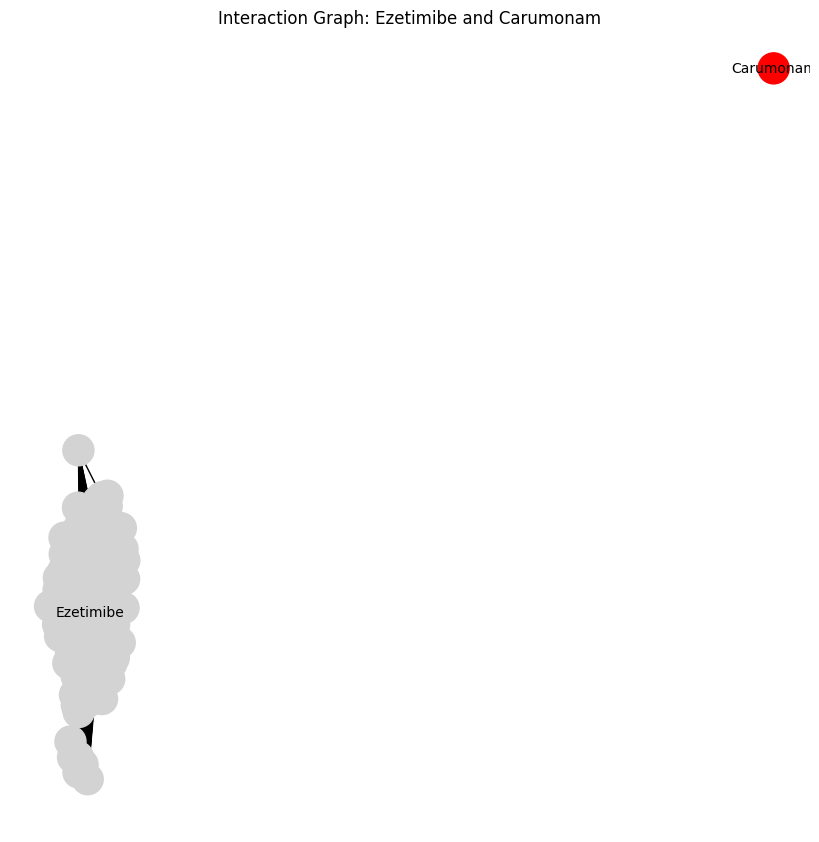

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert PyG graph to NetworkX
G = to_networkx(ddi_graph, to_undirected=True)

# Function to get index of a drug by name
def get_node_index(drug_name):
    row = drug_df[drug_df['name'].str.lower() == drug_name.lower()]
    if row.empty:
        return None
    drug_id = row['drugbank_id'].values[0]
    return drug_id_to_index.get(drug_id)

# Define the drugs
drug1 = "Ezetimibe"
drug2 = "Carumonam"

# Get their node indices
idx1 = get_node_index(drug1)
idx2 = get_node_index(drug2)

if idx1 is None or idx2 is None:
    print("❌ One or both drugs not found.")
else:
    # Get neighbors for context
    nodes_to_show = set([idx1, idx2])
    nodes_to_show.update(G.neighbors(idx1))
    nodes_to_show.update(G.neighbors(idx2))

    # Build subgraph
    subG = G.subgraph(nodes_to_show)

    # Color and label nodes
    color_map = []
    labels = {}
    for node in subG.nodes():
        if node == idx1:
            color_map.append("green")
            labels[node] = drug1
        elif node == idx2:
            color_map.append("red")
            labels[node] = drug2
        else:
            color_map.append("lightgray")

    # Draw the graph
    plt.figure(figsize=(8, 8))
    nx.draw(subG, with_labels=True, labels=labels, node_color=color_map, node_size=500, font_size=10)
    plt.title(f"Interaction Graph: {drug1} and {drug2}")
    plt.show()


In [19]:
# STEP 1: INSTALL + IMPORT
!pip install torch-geometric torch-scatter -q

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score

# STEP 2: DEFINE MODEL
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# STEP 3: LOAD MODEL + EMBEDDINGS
in_channels = 5
out_channels = 64
model = GAE(GCNEncoder(in_channels, out_channels))
model.load_state_dict(torch.load('gnn_ddi_model.pt'))
model.eval()

z = torch.load('drug_embeddings.pt')  # learned drug embeddings

# STEP 4: LOAD DATA + FIX LENGTH TO MATCH EMBEDDINGS
drug_df = pd.read_csv("/content/drive/MyDrive/drugbank_extracted.csv")
drug_df = drug_df.iloc[:z.size(0)].reset_index(drop=True)  # ✅ FIX: Match with z

# STEP 5: CREATE MAPPING
drug_id_to_index = {row['drugbank_id']: i for i, row in drug_df.iterrows()}

# STEP 6: REBUILD GRAPH
edge_list = []
for i, row in drug_df.iterrows():
    src = i
    if pd.isna(row['interactions']):
        continue
    for tgt_id in str(row['interactions']).split('|'):
        tgt = drug_id_to_index.get(tgt_id)
        if tgt is not None:
            edge_list.append([src, tgt])

edge_index = torch.tensor(edge_list, dtype=torch.long).T
x_dummy = torch.randn(len(drug_df), in_channels)
ddi_graph = Data(x=x_dummy, edge_index=edge_index)

# STEP 7: DEFINE SCORING FUNCTION
def decode_pairs(z, edge_index):
    scores = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
    return torch.sigmoid(scores)

# STEP 8: GENERATE POSITIVE & NEGATIVE EDGES
pos_edge_index = ddi_graph.edge_index
neg_edge_index = negative_sampling(
    edge_index=pos_edge_index,
    num_nodes=z.size(0),
    num_neg_samples=pos_edge_index.size(1)
)

# STEP 9: SCORE + EVALUATE
pos_scores = decode_pairs(z, pos_edge_index)
neg_scores = decode_pairs(z, neg_edge_index)

all_scores = torch.cat([pos_scores, neg_scores])
labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))])

all_scores_np = all_scores.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()

auc = roc_auc_score(labels_np, all_scores_np)
acc = accuracy_score(labels_np, (all_scores_np >= 0.5).astype(int))

print(f"✅ ROC AUC Score: {auc:.4f}")
print(f"✅ Accuracy Score: {acc:.4f}")


✅ ROC AUC Score: 0.5906
✅ Accuracy Score: 0.5525
